battery json data  convert to matrix and input to CNN for train，没有容量特征字段

In [1]:
from sklearn import preprocessing 
from scipy.io import loadmat, whosmat
import numpy as np
import datetime
import json
import os
# 获取得到 json data of battery 
def json_load(dictonary):
    with open(dictonary) as f:
        data = json.load(f)
    return data

'''
cycle为行数，循环读取一行数据，对一行数据里面的voltage,current and temp求均值，并添加capacity features
得到battery array
'''
def batteryData2array(battery_data):
    vol_sum = 0
    cur_sum = 0
    temp_sum=0
    battery_array = []
    for cycle in battery_data.keys():
        # list type 
        battery_vols = battery_data[cycle]["voltage_battery"]
        battery_curs = battery_data[cycle]["current_battery"]
        battery_temps=battery_data[cycle]["temp_battery"]
        battery_capacity=battery_data[cycle]["Capacity"]
        for battery_vol in battery_vols:
            vol_sum += float(battery_vol)
        for battery_cur in battery_curs:
            cur_sum += float(battery_cur)
        for battery_temp in battery_temps:
            temp_sum += float(battery_temp)
        #for voltage and current average  & battery_vols,battery_curs,battery_temps's len is equal
        num = len(battery_vols)
        vol_aver = vol_sum / num
        cur_aver = cur_sum / num
        temp_aver=temp_sum/num
        vol_sum = 0
        cur_sum = 0
        temp_sum=0
        battery_array.append([vol_aver,cur_aver,temp_aver])
#         battery_array.append([vol_aver,cur_aver,battery_capacity[0]])
    return battery_array

# get battery's true soc
def  getTrueSOC(battery_discharge_data):
    batteryCapcity=2
    soc_dict=[]
    for cycle in battery_discharge_data.keys():
        cycleCapacity=battery_discharge_data[cycle]["Capacity"]
        soc_true=cycleCapacity[0]/batteryCapcity
        soc_dict.append(soc_true)
    return soc_dict

# get battery's discgarge capacity
def  getTrueCapacity(battery_discharge_data):
    capacity=[]
    for cycle in battery_discharge_data.keys():
        cycleCapacity=battery_discharge_data[cycle]["Capacity"]
        capacity.append(cycleCapacity[0])
    return capacity

'''
获取得到 battery 's img matrix 图像矩阵  4维特征向量  vol_aver,cur_aver,temp_aver,battery_capacity
返回battery discharge matrix and true soc array
'''
def batterydata2matrix(discharge):
    #get the discharge and charge json data
    discharge_data =json_load(discharge)
    
    #get the true soc data
    true_soc=getTrueSOC(discharge_data)
#   true_capacity=getTrueCapacity(discharge_data)
    #get the battery discharge array data  convert to matrix
    discharge_array = batteryData2array(discharge_data)
    discharge_matrix = np.array(discharge_array)

    discharge_matrix=preprocessing.scale(discharge_matrix)
    return discharge_matrix,true_soc

'''
获取得到每一节电池数据的训练数据集
得到train & test data
'''
def getTrainData(discharge_matrix,true_soc):     
    #循环切片形成数据集
    x=[];y=[]
    x_train=[];y_train=[]
    flag=0

    # 获取得到x,y的数据集
    for i in range(len(discharge_matrix.tolist())):
        #首先截取长度为8的矩阵，叠加循环得到x
        bataery_data_training=discharge_matrix[flag:flag+8,:]
    #     print(bataery_data_training.shape)
        if(len(bataery_data_training)<8):
            break
        else:
            #进行转置，形成4*T的时间维度
            x.append(bataery_data_training.T)
        flag+=1
    #0-》t时刻d x 预测得到t时刻的soc。为了对soc 进行预测，y矩阵为【7：】
    y=true_soc[8:]
    x=x[:len(x)-1]
#     y=true_capacity[8:]

    VALIDATION_SPLIT=0.9
    x_validation_samples = int( VALIDATION_SPLIT* len(x))
    y_validation_samples = int( VALIDATION_SPLIT*len(y))
    
    
    # 获取得到训练集，验证集，比例9:1
    x_train=np.array(x[:x_validation_samples])
    x_test=np.array(x[x_validation_samples:])
    y_train=np.array(y[:y_validation_samples])
    y_test=np.array(y[y_validation_samples:])
    print("x_train's shape is:", x_train.shape,"，y_train's shape is:",y_train.shape)
    print("x_test's shape is:",x_test.shape,"，y_test's shape is:",y_test.shape)
    return x_train,x_test,y_train,y_test

In [2]:
# 定义全局变量，将所有电池数据集集合起来，形成训练集，测试集
# x_train_all,x_test_all,y_train_all,y_test_all=[],[],[],[]
for i in range(5,8):
    #/home/aqts/yangHong/battery experiment/jsonData
    discharge=r'/home/aqts/yangHong/battery experiment/jsonData/B000'+str(i)+'_discharge.json'
    discharge_matrix,true_soc=batterydata2matrix(discharge)
    train_x,test_x,train_y,test_y=getTrainData(discharge_matrix,true_soc)
    # start 开始时先赋值给x_train_all，x_test_all，y_train_all，y_test_all
    if i==5:
        x_train_all=train_x
        x_test_all=test_x
        y_train_all=train_y
        y_test_all=test_y
    else:
        x_train_all=np.concatenate((x_train_all,train_x),axis=0)
        x_test_all=np.concatenate((x_test_all,test_x),axis=0)
        y_train_all=np.concatenate((y_train_all,train_y),axis=0)
        y_test_all=np.concatenate((y_test_all,test_y),axis=0)
print(np.array(x_train_all).shape,np.array(x_test_all).shape,np.array(y_train_all).shape,np.array(y_test_all).shape)


x_train's shape is: (144, 3, 8) ，y_train's shape is: (144,)
x_test's shape is: (16, 3, 8) ，y_test's shape is: (16,)
x_train's shape is: (144, 3, 8) ，y_train's shape is: (144,)
x_test's shape is: (16, 3, 8) ，y_test's shape is: (16,)
x_train's shape is: (144, 3, 8) ，y_train's shape is: (144,)
x_test's shape is: (16, 3, 8) ，y_test's shape is: (16,)
(432, 3, 8) (48, 3, 8) (432,) (48,)


In [3]:
#写一个LossHistory类，保存loss和mae
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D,Convolution2D
from keras import backend as k
import matplotlib.pyplot as plt
import numpy as np
from keras import backend as K
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}

    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('mean_absolute_error'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_mean_absolute_error'))

    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('mean_absolute_error'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_mean_absolute_error'))

    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        # mae
        plt.plot(iters, self.accuracy[loss_type], 'r', label='train mae')
        # loss
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            # val_mean_absolute_error
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val mean absolute error')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('mae-loss')
        plt.legend(loc="upper right")
        plt.show()

/home/aqts/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


基于序贯(Sequential)编程方式的模型

In [13]:
#使用cnn训练的模型
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D,Convolution2D,GRU,LSTM
from keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
from keras import regularizers
from keras.optimizers import SGD, Adam
from keras.layers.normalization import BatchNormalization
import tensorflow as tf
from keras.layers.noise import GaussianNoise
# 引用GPU命令
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

num=1
img_rows, img_cols =x_train_all.shape[1],x_train_all.shape[2]
if K.image_dim_ordering() == 'th':
    x_train_all = x_train_all.reshape(x_train_all.shape[0], 1, img_rows, img_cols)
    x_test_all = x_test_all.reshape(x_test_all.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train_all = x_train_all.reshape(x_train_all.shape[0], img_rows, img_cols, 1)
    x_test_all= x_test_all.reshape(x_test_all.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    
# lstm_layer=(None, input_shape[0], input_shape[1], input_shape[2])
# print(x_train.shape,x_test.shape)
# print(y_train.shape)
# keras序贯模型搭建CNN
# model building
model = Sequential()
#convolutional layer with rectified linear unit activation
model.add(Conv2D(64, kernel_size=(1,2),
                 activation='relu',
                 input_shape=input_shape,padding="same"))
#32 convolution filters used each of size 3x3
#again
model.add(Conv2D(128, (2,2), activation='relu',padding="same"))
#64 convolution filters used each of size 3x3
#choose the best features via pooling
model.add(MaxPooling2D(pool_size=(1, 2)))

model.add(Conv2D(32, (2,1), activation='relu',padding="same"))

model.add(Conv2D(64, (2,2), activation='relu',padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2)))
#randomly turn neurons on and off to improve convergence
# model.add(Dropout(0.30))
#flatten since too many dimensions, we only want a classification output
model.add(Flatten())
#fully connected to get all relevant data
model.add(Dropout(0.20))
model.add(Dense(16, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.20))

model.add(Dense(16, activation='relu'))
model.add(Dropout(0.20))
# model.add(Dense(num, activation='sigmoid'))
# The last layer does not use the activation function
model.add(Dense(num))

#Adaptive learning rate (adaDelta) is a popular form of gradient descent rivaled only by adam and adagrad
#categorical ce since we have multiple classes (10) 
# model.compile(loss=keras.losses.sparse_categorical_crossentropy,
#               optimizer=keras.optimizers.Adadelta(),
#               metrics=['accuracy'])
#回归问题评价指标使用mae
model.compile(loss='mse', optimizer="sgd", metrics=["mae"])

model.summary()
batch_size =16
num_epoch = 128



# decay_rate = learning_rate / num_epoch
# momentum = 0.8
# sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)

# model.compile(loss='mse', optimizer=sgd, metrics=["mae"])
#model training
history = LossHistory()
model.fit(x_train_all, y_train_all,
          batch_size=batch_size,
          epochs=num_epoch,
          verbose=1,validation_split=0.3,callbacks=[history])

mse_score,mae_score= model.evaluate(x_test_all, y_test_all, verbose=0)
print('Test MSE Score:%.3f %%'% (mse_score*100)) 
print('Test MAE Score:%.3f %%'% (mae_score*100))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 3, 8, 64)          192       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 3, 8, 128)         32896     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 3, 4, 128)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 3, 4, 32)          8224      
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 3, 4, 64)          8256      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 1, 2, 64)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 128)               0         
__________

302/302 [==============================] - 0s 429us/step - loss: 0.0352 - mean_absolute_error: 0.0662 - val_loss: 0.0294 - val_mean_absolute_error: 0.0351
Epoch 38/128
302/302 [==============================] - 0s 421us/step - loss: 0.0344 - mean_absolute_error: 0.0641 - val_loss: 0.0294 - val_mean_absolute_error: 0.0352
Epoch 39/128
302/302 [==============================] - 0s 420us/step - loss: 0.0341 - mean_absolute_error: 0.0607 - val_loss: 0.0294 - val_mean_absolute_error: 0.0359
Epoch 40/128
302/302 [==============================] - 0s 370us/step - loss: 0.0348 - mean_absolute_error: 0.0665 - val_loss: 0.0293 - val_mean_absolute_error: 0.0345
Epoch 41/128
302/302 [==============================] - 0s 347us/step - loss: 0.0343 - mean_absolute_error: 0.0631 - val_loss: 0.0295 - val_mean_absolute_error: 0.0372
Epoch 42/128
302/302 [==============================] - 0s 368us/step - loss: 0.0344 - mean_absolute_error: 0.0641 - val_loss: 0.0297 - val_mean_absolute_error: 0.0396
Epoch

Epoch 86/128
302/302 [==============================] - 0s 368us/step - loss: 0.0309 - mean_absolute_error: 0.0496 - val_loss: 0.0282 - val_mean_absolute_error: 0.0331
Epoch 87/128
302/302 [==============================] - 0s 385us/step - loss: 0.0311 - mean_absolute_error: 0.0510 - val_loss: 0.0284 - val_mean_absolute_error: 0.0349
Epoch 88/128
302/302 [==============================] - 0s 377us/step - loss: 0.0308 - mean_absolute_error: 0.0499 - val_loss: 0.0283 - val_mean_absolute_error: 0.0346
Epoch 89/128
302/302 [==============================] - 0s 432us/step - loss: 0.0304 - mean_absolute_error: 0.0458 - val_loss: 0.0284 - val_mean_absolute_error: 0.0361
Epoch 90/128
302/302 [==============================] - 0s 405us/step - loss: 0.0310 - mean_absolute_error: 0.0488 - val_loss: 0.0282 - val_mean_absolute_error: 0.0342
Epoch 91/128
302/302 [==============================] - 0s 405us/step - loss: 0.0304 - mean_absolute_error: 0.0457 - val_loss: 0.0283 - val_mean_absolute_error:

将CNN模型使用函数式编程的模式

In [153]:
# keras 函数时搭建cnn模型
# model building
from keras.models import Input,Model
cnn_main_input = Input(shape=input_shape, dtype='float32')
#convolutional layer with rectified linear unit activation
cnn=Conv2D(64, kernel_size=(1,2),
                 activation='relu',
                 input_shape=input_shape,padding="same")(cnn_main_input)
cnn=Conv2D(128, (2,2), activation='relu',padding="same")(cnn)
cnn=MaxPooling2D(pool_size=(1, 2))(cnn)
# cnn=Dropout(0.20)(cnn)

cnn=Conv2D(32, (2,1), activation='relu',padding="same")(cnn)

cnn=Conv2D(64, (3,2), activation='relu',padding="same")(cnn)
cnn=MaxPooling2D(pool_size=(2,2))(cnn)

cnn=Flatten()(cnn)
# cnn=Dropout(0.20)(cnn)
cnn=Dense(16, activation='relu',kernel_regularizer=regularizers.l2(0.001))(cnn)
cnn=Dropout(0.20)(cnn)

cnn=Dense(16, activation='relu')(cnn)
cnn=Dropout(0.20)(cnn)

# rnn=LSTM(units=nb_lstm_outputs,dropout=0.4, recurrent_dropout=0.1,return_sequences=True)(lstm_main_input)
# rnn=LSTM(64, dropout=0.4, recurrent_dropout=0.1)(rnn)

# # two model connection
# con = concatenate([cnn,rnn], axis=-1)
main_output = Dense(num)(cnn)
model = Model(inputs = cnn_main_input, outputs = main_output)
sgd = SGD(lr=0.005, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='mse', optimizer="sgd", metrics=["mae"])


batch_size =16
num_epoch = 128


model.summary()
# decay_rate = learning_rate / num_epoch
# momentum = 0.8
# sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)

# model.compile(loss='mse', optimizer=sgd, metrics=["mae"])
#model training
history = LossHistory()
model.fit(x_train_all, y_train_all,
          batch_size=batch_size,
          epochs=num_epoch,
          verbose=1,validation_split=0.3,callbacks=[history])

mse_score,mae_score= model.evaluate(x_test_all, y_test_all, verbose=0)
print('Test MSE Score:%.3f %%'% (mse_score*100)) 
print('Test MAE Score:%.3f %%'% (mae_score*100))



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_28 (InputLayer)        (None, 3, 8, 1)           0         
_________________________________________________________________
conv2d_149 (Conv2D)          (None, 3, 8, 64)          192       
_________________________________________________________________
conv2d_150 (Conv2D)          (None, 3, 8, 128)         32896     
_________________________________________________________________
max_pooling2d_60 (MaxPooling (None, 3, 4, 128)         0         
_________________________________________________________________
conv2d_151 (Conv2D)          (None, 3, 4, 32)          8224      
_________________________________________________________________
conv2d_152 (Conv2D)          (None, 3, 4, 64)          12352     
_________________________________________________________________
max_pooling2d_61 (MaxPooling (None, 1, 2, 64)          0         
__________

Epoch 86/128
302/302 [==============================] - 0s 466us/step - loss: 0.0295 - mean_absolute_error: 0.0440 - val_loss: 0.0274 - val_mean_absolute_error: 0.0309
Epoch 87/128
302/302 [==============================] - 0s 465us/step - loss: 0.0302 - mean_absolute_error: 0.0474 - val_loss: 0.0273 - val_mean_absolute_error: 0.0301
Epoch 88/128
302/302 [==============================] - 0s 449us/step - loss: 0.0295 - mean_absolute_error: 0.0456 - val_loss: 0.0273 - val_mean_absolute_error: 0.0298
Epoch 89/128
302/302 [==============================] - 0s 454us/step - loss: 0.0296 - mean_absolute_error: 0.0454 - val_loss: 0.0274 - val_mean_absolute_error: 0.0316
Epoch 90/128
302/302 [==============================] - 0s 448us/step - loss: 0.0294 - mean_absolute_error: 0.0434 - val_loss: 0.0272 - val_mean_absolute_error: 0.0293
Epoch 91/128
302/302 [==============================] - 0s 463us/step - loss: 0.0294 - mean_absolute_error: 0.0448 - val_loss: 0.0273 - val_mean_absolute_error:

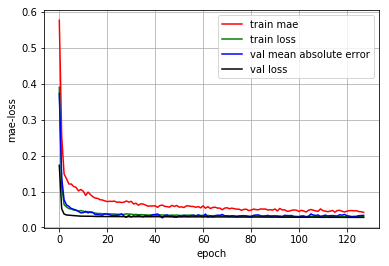

In [10]:
#绘制mae-loss曲线
history.loss_plot('epoch')
# input_shape[]

获取得到需要用于预测的电池数据集B0018号电池

In [6]:
# 获取预测所需的电池数据集
def getBattery008data(discharge_matrix):
    x_pred=[]
    flag=0

    # 获取得到x_pred的数据集
    for i in range(len(discharge_matrix.tolist())):
        #首先截取0--37这段的长度，叠加+1循环得到x
        bataery_data_training=discharge_matrix[flag:flag+8,:]
    #     print(bataery_data_training.shape)
        if(len(bataery_data_training)<8):
            break
        else:
            #进行转置，形成3*T的时间维度
            x_pred.append(bataery_data_training.T)
        flag+=1

    x_pred=np.array(x_pred[:len(x_pred)-1])
    return x_pred

# return prediction  data &  prediction  data true_so
discharge_008=r'/home/aqts/yangHong/battery experiment/jsonData/B0008_discharge.json'
# 获取得到一节电池的 特征向量 与true soc 
discharge_matrix_008,true_soc_008 =batterydata2matrix(discharge_008)
# 得到预测样本集 t=7
x_test_008=getBattery008data(discharge_matrix_008)


print("x_test_008 data shape is",x_test_008.shape)
# 预测数据集进行转换
if K.image_dim_ordering() == 'th':
    x_test_008 = x_test_008.reshape(x_test_008.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_test_008 = x_test_008.reshape(x_test_008.shape[0], img_rows, img_cols,1)
    input_shape = (img_rows, img_cols, 1)

x_test_008 data shape is (124, 3, 8)


In [11]:
pred=model.predict(x_test_008, batch_size=16, verbose=0)
print(pred.shape)

(124, 1)


x_true_soc range is  range(0, 132) 
 x_test_soc_008  range is: range(8, 132)


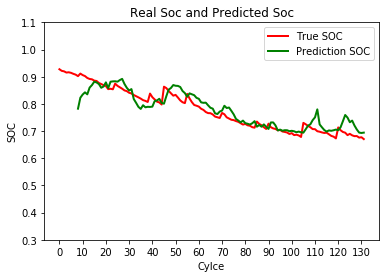

In [12]:
import pandas as pd # 导入pandas库用来处理csv文件
import matplotlib.pyplot as plt # 导入matplotlib.pyplot并用plt简称

# true soc predict plot
x_true_soc=range(len(true_soc_008))
# 切割开始的基数一定为7
start=8
x_test_soc_008=range(start,start+pred.shape[0])
print("x_true_soc range is ",x_true_soc,"\n x_test_soc_008  range is:",x_test_soc_008)
plt.plot(x_true_soc, true_soc_008, linewidth=2.0, color='r',label="True SOC")#线的宽度为2.0，颜色为红色
plt.plot(x_test_soc_008, pred, linewidth=2.0, color='g',label="Prediction SOC")#线的宽度为2.0，颜色为绿色


# 设置x ,y轴的步长与刻度属性
plt.xticks([x for x in range(len(x_true_soc) + 1) if x %10 == 0])  # x标记step设置为10
plt.ylim(ymin=0.3,ymax=1.1)
# remark for x & y
plt.xlabel('Cylce')
plt.ylabel('SOC')
plt.title('Real Soc and Predicted Soc')

plt.legend()
plt.show()#显示图像
